# Assignment2
### Haoze Wang; Alex Chen; Yanxi Li

### We explored 2 method for this assignment

This task required us to use transfer learning to solve the duck image recognition problem, but the three of us were very interested in exploring the differences between transfer learning and a custom simple convolutional neural network for this task. Therefore, we implemented a simple customized convolutional neural network and then a migration learning neural network derived from resnet and compared their results.

Prior to this task, we did data collection. We collected 1000 duck and non-duck images each from the rate training set. Since our model needs to be validated for correctness on top of the limited dataset given by the professor, we did not inject images into the test set.

# Custom-built CNN

### 1. Import reated Libs
We use Pytorch to for this work, so we import pytorch. And we also import some sub sets of it for easier code writing. 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision import transforms

### 2. Define some configs

In this place, we define the path of different dataset with different labels.

In [8]:
PATH_TRAIN_DUCKS = "./Data/train/ducks/"
PATH_TRAIN_NOT_DUCKS = "./Data/train/not_ducks/"
PATH_TEST_DUCKS = "./Data/test/ducks/"
PATH_TEST_NOT_DUCKS = "./Data/test/not_ducks/"

### 2. Hyperparameter configuration.

It is worth mentioning that the epoch we define here is the maximum number of training times. We will choose a reasonable value of epoch according to the performance of the model on the test set to prevent overfiting.

In [9]:
BATCH_SIZE = 30
LEARNING_RATE = 0.001

EPOCH = 15 #Max trainning bound

### 3. Data Preprocess

#### (1) Define the Dataset class

We defined dataset classes that are suitable for the data of this assignment. Generated a python list containing labels while loading images. Considering that the task is a binary classification problem, we set ducks to 1 and non-ducks to 0.

In [10]:
class DuckDataSet(Dataset):

    def __init__(self, path, target = "not_duck", transform = None) -> None:
        # self.features = []; self.targets = []
        self.imagesNameList = [f"{path}{name}" for name in os.listdir(path)]
        self.length = len(self.imagesNameList)
        self.targets = self.length * ([1] if target == "duck" else [0])

        self.transform = transform

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        image = Image.open(self.imagesNameList[index])
        if self.transform:
            image = self.transform(image.convert("RGB"))

        return image, self.targets[index]

#### (2) Define the transform method

We defined the transform method that are suitable for the situation of this assignment and our coming NN class. We formatted the images to (64, 64) and did data normalization as you can see in the code

In [11]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#### (3) Create the DataLoader Class

At this place, we loaded the images in the format of the defined dataset, and then load them into DataLoader.

In [12]:
train_set = DuckDataSet(PATH_TRAIN_DUCKS, target = "duck", transform = transform) + DuckDataSet(PATH_TRAIN_NOT_DUCKS, transform = transform)
test_set = DuckDataSet(PATH_TEST_DUCKS, target = "duck", transform = transform) + DuckDataSet(PATH_TEST_NOT_DUCKS, transform = transform)

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True)

### 4. Define our NN

We have designed a neural network. This neural network is overall divided into 3 parts, with convolutional kernel pooling in the first two parts. The last layer is a fully connected layer.

In [13]:
class DuckCNN(nn.Module):
    def __init__(self):
        super(DuckCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc(x)
        return x

### 5. Train the model

Here we define our loss function and optimizer and use them to train our model. And, after each epoch, we record the current performance of the model on the training set.

In [14]:
model = DuckCNN()


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
accuracy_lis = []

for epoch in range(EPOCH):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze() 
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float().squeeze()  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    accuracy = 100 * correct / total
    accuracy_lis.append(accuracy)

Epoch 1, Loss: 0.3840227425098419
Epoch 2, Loss: 0.5923274159431458
Epoch 3, Loss: 0.4710173010826111
Epoch 4, Loss: 0.19385802745819092
Epoch 5, Loss: 0.30614686012268066
Epoch 6, Loss: 0.14725413918495178
Epoch 7, Loss: 0.29562005400657654
Epoch 8, Loss: 0.05901976302266121
Epoch 9, Loss: 0.01574571803212166
Epoch 10, Loss: 0.05942770838737488
Epoch 11, Loss: 0.0008694540010765195
Epoch 12, Loss: 0.0016011785482987761
Epoch 13, Loss: 0.00425691157579422
Epoch 14, Loss: 0.0008248662343248725
Epoch 15, Loss: 0.0006473190733231604


### 6.  Analysis

We have drawn a graph here to show the trend of accuracy as EPOCH changes.

[54.54545454545455, 58.18181818181818, 69.0909090909091, 70.9090909090909, 70.9090909090909, 87.27272727272727, 90.9090909090909, 92.72727272727273, 94.54545454545455, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


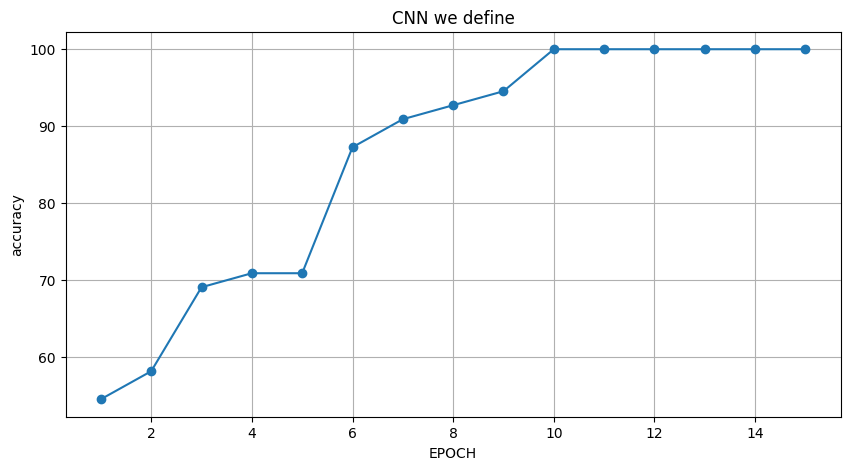

In [16]:
import matplotlib.pyplot as plt

print(accuracy_lis)
x = range(1, 16)


plt.figure(figsize=(10, 5))
plt.plot(x, accuracy_lis, marker='o') 


plt.title('CNN we define')
plt.xlabel('EPOCH')
plt.ylabel('accuracy')

plt.grid(True)
plt.show()


We can see that after the 10th epoch, the model has reached a correctness rate of 100 on the test set. such a result seems to be good, but it actually worries us. Because the amount of data in our training set is much larger than the test set, this may lead us to be unable to make a valid judgment on the generalizability of the model. Since this assignment requires validating the correctness of the model on the test set given by the professor, we did not add images like in the test set.

Under the current conditions, the model after the 10th training seems to be the best, since this is the first time it reaches perfect correctness. But this statement is not always true because of the difference in the amount of data between the test set and the training set that we mentioned earlier.

## Transfering learning from ResNet

### 1. Define our model(from resnet)

In [17]:
from torchvision import models

model_ft = models.resnet152(pretrained = True)
print(model_ft)

c:\Users\LiYan\anaconda3\envs\Yanxi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LiYan\anaconda3\envs\Yanxi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We can see the detailed structures in resnet.

We chose to lock all the layers that extract features from images. We conducted a small experiment and found that using the original parameters is better than training some of them. We think the reason is that our training dataset is much smaller than the original dataset used to train ResNet. Therefore, the parameters of those layers are already very good at extracting features from images; all we need to do is modify the fully-connected layers.

In [18]:
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 2), nn.LogSoftmax(dim = 1))

Here we wrote a code to check the layers waiting for training.

In [19]:
params_to_update = []
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

	 fc.0.weight
	 fc.0.bias


### 2. Set GPU as the caculate device

We used GPU to caculate since the resnet has so many many many parameters. There are still so many parameters waiting for training though we lock all the extracting layers. 

In [20]:
device = torch.device("cuda:0")
model_ft = model_ft.to(device)

### 3. Set a new transforms method

We need a new method to transform and normalize since we use ResNet. We need to be consistent with ResNet's data processing.

In [21]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

### 4. Load the data

In [22]:
train_set = DuckDataSet(PATH_TRAIN_DUCKS, target = "duck", transform = transform) + DuckDataSet(PATH_TRAIN_NOT_DUCKS, transform = transform)
test_set = DuckDataSet(PATH_TEST_DUCKS, target = "duck", transform = transform) + DuckDataSet(PATH_TEST_NOT_DUCKS, transform = transform)

train_loader = DataLoader(train_set, batch_size = 20, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 20, shuffle = True)

### 5. Configure the tools used for training

Here we used StepLR in pytorch, a function that continuously decreases our learning rate during training. So we set the initial learning rate to be large. And the learning rate decreases to 10 percent of the original rate after every 7 EPOCHs.

In [23]:
optimizer_ft = optim.Adam(params_to_update, lr = 1e-2)
schedular = optim.lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)
criterion = nn.NLLLoss()

### 6. Train the model

In [31]:
import copy

accuracy_lis = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set the model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set the model to evaluation mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Only perform backpropagation and optimization in the training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
            if phase == 'test':
                accuracy_lis.append(epoch_acc)

            # Deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('Training completed')
    model.load_state_dict(best_model_wts)
    return model



Call the function and train the model. The returned model_ft is the model that we believe is best adapted to this dataset.

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, schedular, num_epochs=15)

Epoch 1/15
----------
train Loss: 0.2677 Accuracy: 0.9473
test Loss: 3.9858 Accuracy: 0.6727
Epoch 2/15
----------
train Loss: 0.2331 Accuracy: 0.9571
test Loss: 1.1745 Accuracy: 0.8545
Epoch 3/15
----------
train Loss: 0.1717 Accuracy: 0.9615
test Loss: 1.7802 Accuracy: 0.7636
Epoch 4/15
----------
train Loss: 0.1488 Accuracy: 0.9620
test Loss: 0.8667 Accuracy: 0.8545
Epoch 5/15
----------
train Loss: 0.1115 Accuracy: 0.9683
test Loss: 0.9593 Accuracy: 0.8364
Epoch 6/15
----------
train Loss: 0.1177 Accuracy: 0.9717
test Loss: 1.2761 Accuracy: 0.8000
Epoch 7/15
----------
train Loss: 0.1332 Accuracy: 0.9605
test Loss: 0.8515 Accuracy: 0.8545
Epoch 8/15
----------
train Loss: 0.1134 Accuracy: 0.9688
test Loss: 0.7388 Accuracy: 0.8545
Epoch 9/15
----------
train Loss: 0.1227 Accuracy: 0.9688
test Loss: 0.6045 Accuracy: 0.8909
Epoch 10/15
----------
train Loss: 0.1117 Accuracy: 0.9698
test Loss: 0.5530 Accuracy: 0.8909
Epoch 11/15
----------
train Loss: 0.0696 Accuracy: 0.9820
test Loss:

### 7. Analysis

[tensor(0.6727, device='cuda:0', dtype=torch.float64), tensor(0.8545, device='cuda:0', dtype=torch.float64), tensor(0.7636, device='cuda:0', dtype=torch.float64), tensor(0.8545, device='cuda:0', dtype=torch.float64), tensor(0.8364, device='cuda:0', dtype=torch.float64), tensor(0.8000, device='cuda:0', dtype=torch.float64), tensor(0.8545, device='cuda:0', dtype=torch.float64), tensor(0.8545, device='cuda:0', dtype=torch.float64), tensor(0.8909, device='cuda:0', dtype=torch.float64), tensor(0.8909, device='cuda:0', dtype=torch.float64), tensor(0.8909, device='cuda:0', dtype=torch.float64), tensor(0.8727, device='cuda:0', dtype=torch.float64), tensor(0.8364, device='cuda:0', dtype=torch.float64), tensor(0.8727, device='cuda:0', dtype=torch.float64), tensor(0.8364, device='cuda:0', dtype=torch.float64)]


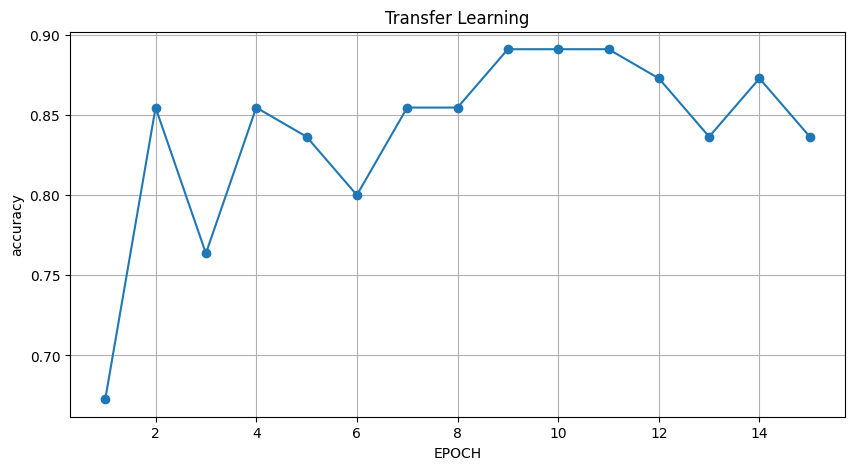

In [36]:
import matplotlib.pyplot as plt

print(accuracy_lis)
x = range(1, 16)


plt.figure(figsize=(10, 5))
plt.plot(x, [t.item() for t in accuracy_lis], marker='o') 


plt.title('Transfer Learning')
plt.xlabel('EPOCH')
plt.ylabel('accuracy')

plt.grid(True)
plt.show()


We can see that the model's performance on the test set keeps jumping around, so we choose the model that performs best on the test set.

In contrast to that convolutional neural network we previously implemented, we believe that the neural network network for transfer learning does a better job of classifying ducks. Although that previous convolutional neural network network performed perfectly on the limited test set given by the professor, there was a huge quantitative difference between the training set and the test set. It is entirely possible that this could lead to a black-box effect. Moreover, the extraction layer of our own convolutional neural network is so simple compared to that of ResNet that we don't think a simple extraction layer can perform well on a wide range of datasets. Therefore, we believe that the transfer learning model is better!